In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import random
np.random.seed(1)

#import ipdb

Referenced paper: https://arxiv.org/pdf/1707.00943.pdf

### Data Generation Functions

In [2]:
def randWalk(d):
    """
    generates a d-dimensional random walk array 
    d: dimension
    """
    y = 0
    arr = np.zeros(d)
    for i in range(d):
        y += np.random.normal(scale=1)
        arr[i] = y
    arr = arr - np.mean(arr) #making it a zero-mean array
    return(arr)

def smooth(arr, windowLen):
    """
    smooths the array by convolutions. takes a moving average 
    of len 'windowLen'
    
    Arguments:
    arr: the array that would be smoothed
    windowLen: specifies the length of the convolution filter
               which determines the number of points that would
               be averaged to generate a point
    """
    box = np.ones(windowLen)/windowLen
    arrSmooth = np.convolve(arr, box, mode='same')
    return(arrSmooth)

def genSignal(d,smoothingWindowLen=1):
    """
    generates a d-dimensional random walk array, where |array| = d
    
    Arguments: 
    d: dimension of the array
    windowLen: length of the convolutions. Bigger values result in a
               more smooth array.
    """
    np.random.seed()
    arr = smooth(randWalk(d),smoothingWindowLen)
    arr = arr * ((d / (np.sum(arr**2)))**.5)
    return(arr)

Samples of the generated signals

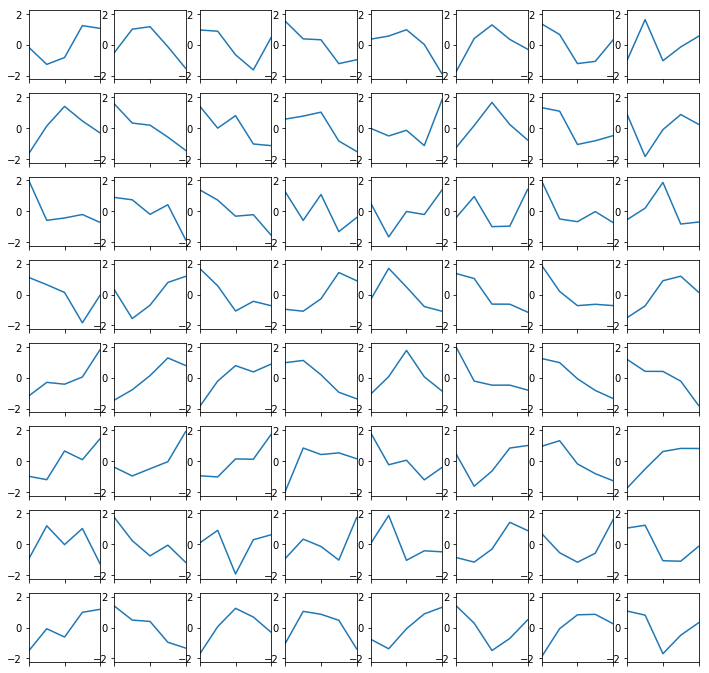

In [3]:
fig = plt.figure(figsize=(12,12))
for i in range(64):
    a = genSignal(d=5)

    ax = fig.add_subplot(8,8,i+1)
    #ax.set_yticklabels([]); 
    ax.set_xticklabels([])
    ax.set_xlim([0, a.size-1]) #ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([-2.25, 2.25])
    plt.plot(a)

### Cyclic Shifts and Noise 

We will use the signal below to demonstrate the data generation process. Let $x \in \mathbb{R}^5$ be a signal. It is generated as follows:
 - First we generate vector $x' \in \mathbb{R}^5$ such that $x'_1 \sim N(0,1)$ and $(x'_i - x'_{i-1} ) \sim N(0,1)$ for $i \in \{2,5\}$. 
 - Then we make $x'$ a zero mean array by subtracting the mean.
 - As this random walk array is generated randomly, ||x'|| is different for each sample $x'$. We generate the final signal $x$ by rescaling $x'$ so that $||x|| = \sum_{i=1}^5 (x_i)^2 = 5$
 - The observations would be generated by applying random cyclic shifts and adding gaussian noise to the underlying signal $x$. Observations that we have are $y^1,y^2, \ldots, y^n$, which are $n$ independent copies of $y \in \mathbb{R}^5$ given by: $$y^i=R_i X + \sigma \xi, \qquad i \in \{1 \ldots n\}, y^i\in \mathbb{R}^5 $$ where the $j$th coordinate after the cyclic shift $R_i x$ is given by $(R_i x)_j := x_{j+u {} \text{(mod 5)}}$, and where $u$ follows the discrete uniform distribution over the set $\{0,1, \ldots, 4\}$. Additionaly $\xi \sim N(0,I_d)$
 
The process is illustrated below with an example.

Underlying signal:

x: [ 1.54762385  0.22180326  0.01388895 -0.19690528 -1.58641077]
|x|:5.00


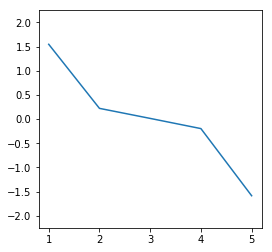

In [4]:
temp_arr = genSignal(d=5)
fig = plt.figure(figsize=(4,4))
plt.plot(np.arange(temp_arr.size)+1,temp_arr)
plt.ylim(-2.25,2.25)
print("x: " + str(temp_arr))
print("|x|:{:.2f}".format(np.sum(np.square(temp_arr))))

In the plots below, blue lines represent $R x$, the signal after a random cyclic shift is applied. Red points represents the observations and are generated by adding a gaussian noise $N(0,4)$ to each coordinate of $R x$. Note that the $SNR = \frac{\sigma_x^2}{\sigma_{noise}^2} = 4$

I have again used a GNN inputs, and calculated the minimum loss given by the all cyclic shifts: $\text{loss} = \text{min}_{R} \{ (y_{\text{pred}} - R y_{\text{true}})^2 \}$

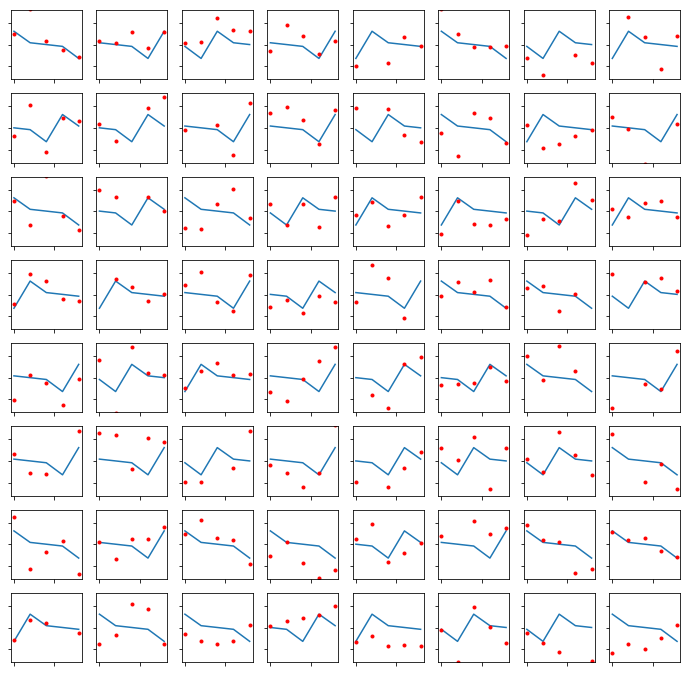

In [5]:
fig = plt.figure(figsize=(12,12))
for i in range(64):
    # random cyclic shift
    if i == 0:
        arrShifted = temp_arr
    else:
        arrShifted = np.roll(temp_arr,np.random.randint(temp_arr.size))
    # random gaussian noise
    a = arrShifted + np.random.normal(scale=2,size=temp_arr.size)

    ax = fig.add_subplot(8,8,i+1)
    ax.set_yticklabels([]); 
    ax.set_xticklabels([])#ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([-4, 4])
    plt.plot(arrShifted)
    plt.plot(a,'or',markersize=3)

# Training and Evaluation

In [6]:
import numpy as np
import tensorflow as tf
import datetime
import multiprocessing as mp
from multiprocessing.pool import ThreadPool
from src import *

In [7]:
def dense(x, scope, num_h, n_x):
    """
    Standard affine layer
    
    scope = name tf variable scope
    num_h = number of hidden units
    num_x = number of input units
    """
    with tf.variable_scope(scope):
        w = tf.get_variable('w', [n_x, num_h], initializer=tf.random_normal_initializer(stddev=0.04))
        b = tf.get_variable('b', [num_h], initializer=tf.constant_initializer(0))
        return tf.matmul(x, w)+b


    
def conv(x, scope, filter_h,filter_w, n_kernel, stride_h=1,stride_w=1, padding='SAME'):
    """
    Convolutional layer
    
    scope        = name tf variable scope
    filter_h     = height of the receptive field
    filter_w     = width of the receptive field
    n_kernel     = # of kernels
    stride_h     = stride height
    stride_w     = stride width
    """
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        n_x = x.get_shape().as_list()[-1]
        w = tf.get_variable('w',
                            [filter_h, filter_w, n_x, n_kernel],
                            initializer=tf.random_normal_initializer(stddev=0.04))
        b = tf.get_variable('b', [n_kernel], initializer=tf.constant_initializer(0))
        return tf.nn.convolution(x, w, padding=padding, strides=[stride_h, stride_w])+b    


def bnorm(X,isTraining,scope='batch_norm',axis=-1):
    """
    Batch normalization layer
    
    X          = input
    isTraining = True during training, False otherwise.
    axis       = axis for normalization
    scope      = name tf variable scope
    
    """
    return(tf.layers.batch_normalization(
        inputs=X,
        axis=axis, 
        training = isTraining,
        name=scope
    ))
    
def convObservations(X,batch_size,n_images,isTraining=False, reuse=False,scope='convObservations',encDim=128):
    """
    Makes convolutions over noisy signals with cyclic shifts.
    X.size = (batch_size,nObservations, signalDim,1 ). Returns the average 
    value of the encodings of the observations
    """
 #   ipdb.set_trace() 
    with tf.variable_scope('convObservations', reuse=reuse):
        h = tf.nn.leaky_relu(conv(X, 'conv0',1,5,32,1,1), 0.2)  # 5x64
        h = bnorm(h,isTraining,'bnorm_1d_0')
        h = tf.nn.leaky_relu(conv(h, 'conv1',1,3,64,1,1), 0.2)  # 5x64
        h = bnorm(h,isTraining,'bnorm_1d_1')
        h = tf.nn.leaky_relu(conv(h, 'conv2',1,3,64,1,2), 0.2)  # 3x128
        h = bnorm(h,isTraining,'bnorm_1d_2')
        h = tf.nn.leaky_relu(conv(h, 'conv3',1,3,128,1,2), 0.2)  # 2x128
        h = bnorm(h,isTraining,'bnorm_1d_3')
        h = tf.reshape(h, [-1, 256])
        
        h = tf.nn.leaky_relu(dense(h, 'fc_0', 128,256), 0.2)
        h = bnorm(h,isTraining,'bnorm_1d_fc0')
        h = tf.nn.leaky_relu(dense(h, 'fc_1', encDim,128), 0.2)
        h = bnorm(h,isTraining,'bnorm_1d_fc1')
        h = tf.reshape(h, [-1, n_images, encDim]) 

        h = tf.reduce_mean(h, 1)
        return(h)        

    

def generator(X, batch_size, isTraining=False, reuse=False,nObservationsPerSignal=30):
    """
    Takes encoding produced by the observations as input and
    generates a the underlying true signal
    """
    with tf.variable_scope('generator', reuse=reuse):
        o = convObservations(X, 
                             batch_size,
                             nObservationsPerSignal,
                             isTraining=True,
                             scope = 'gen_convObserv',
                             encDim=128
                            )
        h = tf.nn.leaky_relu(dense(o, 'g_hz0', num_h=128,n_x=128), 0.2)
        h = tf.concat([o, h], 1)
        h = bnorm(h,isTraining,'bnorm_g_hz0')
        h = tf.nn.leaky_relu(dense(h, 'g_hz1', num_h=64,n_x=128+128), 0.2)
        h = tf.concat([o, h], 1)
        h = bnorm(h,isTraining,'bnorm_g_hz1')
        h = tf.nn.leaky_relu(dense(h, 'g_hz2', num_h=16,n_x=64+128), 0.2)
        h = tf.concat([o, h], 1)
        h = bnorm(h,isTraining,'bnorm_g_hz2')
        h = tf.nn.leaky_relu(dense(h, 'g_hz3', num_h=5,n_x=16+128), 0.2)
        h = dense(h, 'g_hz4', num_h=5,n_x=5)
        
        return(h)    

        
def discriminator(X,obs,minibatchSize, nObservationsPerSignal,isTraining=True, reuse=False):
    """
    Conditional GAN disriminator
  
    Arguments:
    X:   generated sigal
    obs:  observations 
    nObservationsPerSignal:   num of observations we have per signal
    isTraining :  True during training, False otherwise.
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        o = convObservations(obs, 
                             minibatchSize,
                             nObservationsPerSignal,
                             isTraining=True,
                             scope = 'discr_convObserv'
                            )
        h = tf.concat([X, o], 1)
        h = bnorm(h,isTraining,'bnorm_d_hz0')
        h = tf.nn.leaky_relu(dense(h, 'd_hz0', num_h=64,n_x=128+5), 0.2)
        h = tf.concat([X, h], 1)
        h = bnorm(h,isTraining,'bnorm_d_hz1')
        h = tf.nn.leaky_relu(dense(h, 'd_hz1', num_h=32,n_x=64+5), 0.2)
        h = tf.concat([X, h], 1)
        h = bnorm(h,isTraining,'bnorm_d_hz2')
        h = tf.nn.leaky_relu(dense(h, 'd_hz2', num_h=16,n_x=32+5), 0.2)
        h = tf.concat([X, h], 1)
        h = bnorm(h,isTraining,'bnorm_d_hz3')
        h = tf.nn.leaky_relu(dense(h, 'd_hz3', num_h=8,n_x=16+5), 0.2)
        logits = dense(h, 'd_fz', num_h=1,n_x=8)
        return logits
            
        
def cross_entropy_loss(logits, labels):
    """
    default GAN training loss
    """
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))    

class SignalSet:
    """
    A set containing last n generated signals
    """
    def __init__(self,signalDim,batchSize,totalBatchesLim = 50,nObs=0):
        self._itId = 0
        self.signalDim = signalDim
        self.batchSize = batchSize
        self.totalBatchesLim = totalBatchesLim
        self.nObs=nObs
        if (nObs==0):
            self.signalSet=np.ones((0,signalDim),dtype='float32')
        else:
            self.signalSet=np.ones((0,nObs,signalDim,1),dtype='float32')
        
    def insertSignal(self,newSignal):
        if (self.signalSet.shape[0] <self.totalBatchesLim*self.batchSize):
            self.signalSet = np.vstack((self.signalSet,newSignal))
        else:
            self.signalSet[
                (self._itId*self.batchSize):((self._itId+1)*self.batchSize),:] = newSignal
            self._itId = self._itId +1 if self._itId<self.totalBatchesLim-1 else 0
    def getSignalSet(self):
        return(self.signalSet)

class objGenNetwork(object):
    """
    Implementation of the model
    """
    def __init__(self,
                 signalDim = 5,
                 nObservationsPerSignal = 64,
                 noise = 2,
                 minibatchSize = 64,
                 testSampleSize = 1000,
                 lr = 0.001,
                 training = True,
                 skipStep = 1,
                 discTrainWithNBatches=50,
                 vers='v1'
                ):
        self.signalDim = signalDim
        self.nObservationsPerSignal = nObservationsPerSignal
        self.noise = noise
        self.minibatchSize = minibatchSize
        self.testSampleSize = testSampleSize
        self.lr = lr
        self.isTraining = training
        self.skipStep = skipStep
        self.vers = vers
        self.discTrainWithNBatches = discTrainWithNBatches
        self.gstep = tf.Variable(0, 
                                 dtype=tf.int32, 
                                 trainable=False,
                                 name='global_step')
        self.train_x = None
        self.train_y = None
        self.train_y_wo_shifts = None
        self.test_x = None
        self.test_y = None
        self.test_y_wo_shifts = None
        self.lastNGenSignals = SignalSet(signalDim,minibatchSize,discTrainWithNBatches)
        self.lastNTrueSignals = SignalSet(signalDim,minibatchSize,discTrainWithNBatches)
        self.lastNObs = SignalSet(signalDim,minibatchSize,discTrainWithNBatches,nObs=nObservationsPerSignal)
        self.lsDisc = 99999
        self.lsGen = 99999

        for i in range(discTrainWithNBatches):
            self.lastNGenSignals.insertSignal(np.zeros((minibatchSize,signalDim),dtype='float32'))
            self.lastNTrueSignals.insertSignal(np.zeros((minibatchSize,signalDim),dtype='float32'))
            self.lastNObs.insertSignal(np.zeros((minibatchSize,nObservationsPerSignal,signalDim,1),dtype='float32'))
        
    def data_generator(self,trainingBatch=True):

        """
        Generates batches of random signals and their noisy 
        observations with cyclic shifts. |Signal| = dim(Signal)
        """
        minibatchSize = self.minibatchSize
        testSampleSize = self.testSampleSize
        signalDim = self.signalDim
        noise = self.noise
        nObservationsPerSignal=self.nObservationsPerSignal
        
        
        batches = minibatchSize if trainingBatch else testSampleSize


        arrs = [genSignal(d=signalDim).astype('float32') for i in range(batches)]
        batch_y_wo_shifts = np.array(arrs)
        
        arrShifted = np.array([np.roll(a,np.random.randint(signalDim)) \
                               + np.random.normal(scale=noise,size=signalDim) 
                               for a in arrs for i in range(nObservationsPerSignal)])
        arrShifted= np.reshape(arrShifted,(batches,nObservationsPerSignal,signalDim))

        arrs = np.array([np.roll(a,i) for a in arrs for i in range(signalDim)])
        arrs= np.reshape(arrs,(batches,signalDim,signalDim))

        batch_x = np.expand_dims(arrShifted,axis=3)
        batch_y = arrs #np.expand_dims(arrs,axis=3)
        

        if trainingBatch:
            self.train_x_new = batch_x
            self.train_y_new = batch_y
            self.train_y_new_wo_shifts = batch_y_wo_shifts
        else:
            self.test_x_new = batch_x
            self.test_y_new = batch_y
            self.test_y_new_wo_shifts = batch_y_wo_shifts
        
        
    def inference(self):
        # generator
        self.preds = generator(self.x_ph,
                               self.minibatchSize, 
                               isTraining=self.isTraining,
                               nObservationsPerSignal=self.nObservationsPerSignal)
        
        
        # dicriminator that tries to classify the fake signals
        self.discr_z = discriminator(
            self.preds,
            self.x_ph,
            self.minibatchSize,
            self.nObservationsPerSignal,
            isTraining=self.isTraining
        )
                
        # dicriminator that tries to classify the true underlying signals
        self.discr_x = discriminator(
            self.y_ph_wo_shifts,
            self.x_ph,
            self.minibatchSize,
            self.nObservationsPerSignal,
            isTraining=self.isTraining,
            reuse = True   #
        ) 
        
        # dicriminator that tries to classify the last n fake signals
        self.discr_z_last_n = discriminator(
            self.z_ph_last_n,
            self.obs_last_n,
            self.minibatchSize,
            self.nObservationsPerSignal,
            isTraining=self.isTraining,
            reuse=True
        )
        # dicriminator that tries to classify the last n true signals
        self.discr_x_last_n = discriminator(
            self.y_ph_last_n,
            self.obs_last_n,
            self.minibatchSize,
            self.nObservationsPerSignal,
            isTraining=self.isTraining,
            reuse=True
        )
        
    def loss(self):
        """
        Defines loss function
        We use mean squared loss over the predicted and the true signal
        under the best fitting cyclic shift.
        """
        # 
        with tf.name_scope('loss'):
            #generator tries to get discriminator to classify its samples as real
            self.g_loss= cross_entropy_loss(logits=self.discr_z, 
                                            labels=tf.ones(tf.shape(self.discr_z)))
            #discriminator tries to classify generator samples as fake
            d_g_z_loss = cross_entropy_loss(logits=self.discr_z, 
                                            labels=tf.zeros(tf.shape(self.discr_z)))
            #discriminator tries to classify data samples as real
            d_x_loss = cross_entropy_loss(logits=self.discr_x,
                                          labels=tf.ones(tf.shape(self.discr_x)))
            #discriminator tries to classify the last n generator samples as fake
            d_g_z_last_n_loss = cross_entropy_loss(logits=self.discr_z_last_n, 
                                            labels=tf.zeros(tf.shape(self.discr_z_last_n)))
            #discriminator tries to classify the last n data samples as real
            d_x_last_n_loss = cross_entropy_loss(logits=self.discr_x_last_n,
                                          labels=tf.ones(tf.shape(self.discr_x_last_n)))
            #overall discriminator objective is correctly classifying both real and fake data
            self.d_loss = (d_g_z_loss + d_x_loss+4*d_g_z_last_n_loss+4*d_x_last_n_loss)/10
            

    def optimize(self):
        """
        Optimization op
        """
        tvars = tf.trainable_variables()
        dVars = [var for var in tvars if 'discriminator' in var.name]
        gVars = [var for var in tvars if 'generator' in var.name]

        #g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
        with tf.control_dependencies(gVars):
            self.opt_g = tf.train.AdamOptimizer(self.lr).minimize(
                self.g_loss,
                var_list=gVars,
                global_step=self.gstep
            )
        #d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
        with tf.control_dependencies(dVars):
            self.opt_d = tf.train.AdamOptimizer(self.lr).minimize(
                self.d_loss,
                var_list=dVars
            )

    def eval_graph(self):
        """
        Takes the most accurate rotation of the true object
        as reference and calculates the average accuracy of
        the occupancy grid of the object
        """
        with tf.name_scope('prediction_eval'):
            tiledPreds = tf.tile(tf.expand_dims(self.preds, 1),
                                 [1,self.signalDim,1])
            MAE = tf.reduce_sum(tf.abs(tiledPreds - self.y_ph),
                                axis = 2)
            MAE = tf.reduce_min(MAE,axis=1)
            self.MAE = tf.reduce_mean(MAE,name="MAE")
            
            tiled_preds = tf.tile(tf.expand_dims(self.preds, 1),[1,self.signalDim,1])
            entropy = tf.squared_difference(self.y_ph,tiled_preds)
            entropy = tf.reduce_sum(entropy, axis = 2)
            entropy = tf.reduce_min(entropy,axis = 1)
            self.l2Loss = tf.reduce_mean(entropy, name='l2_Loss')
       
        
    def eval_once(self, sess, writer, epoch, step):
        self.isTraining = False
        MAE_batch, l2Loss,gLoss,dLoss, summaries = sess.run(
            [self.MAE,
             self.l2Loss,
             self.g_loss,
             self.d_loss,
             self.summary_op],
            feed_dict={
                self.x_ph: self.test_x_new,
                self.y_ph: self.test_y_new,
                self.y_ph_wo_shifts: self.test_y_new_wo_shifts,
                self.obs_last_n:self.lastNObs.getSignalSet(),
                self.y_ph_last_n:self.lastNTrueSignals.getSignalSet(),
                self.z_ph_last_n:self.lastNGenSignals.getSignalSet()
            }
        )
        writer.add_summary(summaries, global_step=step)
        print('test MAE at step {0}: {1} '.format(step,MAE_batch))
        print('test l2-loss at step {0}: {1} '.format(step,l2Loss))
        print('test gen-loss at step {0}: {1} '.format(step,gLoss))
        print('test disc-loss at step {0}: {1} '.format(step,dLoss))
        


    def summary(self):
        """
        Summary for TensorBoard
        """
        with tf.name_scope('summaries'):
            tf.summary.scalar('l2_loss', self.l2Loss)
            tf.summary.scalar('MAE', self.MAE)
            tf.summary.scalar("Generator_s_Loss", self.g_loss)
            tf.summary.scalar("Discriminator_s_Loss", self.d_loss)
            tf.summary.histogram("Generator_s_Loss", self.g_loss)
            tf.summary.histogram("Discriminator_s_Loss", self.d_loss)
            self.summary_op = tf.summary.merge_all()

    def build(self):
        """
        Builds the computation graph
        """
        self.x_ph = tf.placeholder(tf.float32, [None, 
                                                None,
                                                self.signalDim,
                                                1]) 
        self.y_ph = tf.placeholder(tf.float32, [None,
                                                self.signalDim,
                                                self.signalDim])
        self.y_ph_wo_shifts = tf.placeholder(
            tf.float32,
            [None,self.signalDim]
        ) 
        self.y_ph_last_n = tf.placeholder(
            tf.float32,
            [None,self.signalDim]
        )
        self.z_ph_last_n = tf.placeholder(
            tf.float32,
            [None,self.signalDim]
        )
        
        self.obs_last_n = tf.placeholder(
            tf.float32,
            [None,None,self.signalDim,1]
        )
        
                                         
        self.data_generator()
        self.inference()
        self.loss()
        self.optimize()
        self.eval_graph()
        self.summary()
    
    def train_one_epoch(self, sess, saver, writer, epoch, step):
#        start_time = time.time()
        self.isTraining = True
        if (self.lsDisc <.55 and self.lsGen>self.lsGen*1.75):
            _g, self.lsGen,self.lsDisc, summaries,gen_z = sess.run([
                #self.opt_d,
                self.opt_g,
                self.g_loss,
                self.d_loss,
                self.summary_op,
                self.preds
            ],
                feed_dict={
                    self.x_ph: self.train_x_new,
                    self.y_ph: self.train_y_new,
                    self.y_ph_wo_shifts: self.train_y_new_wo_shifts,
                    self.y_ph_last_n:self.lastNTrueSignals.getSignalSet(),
                    self.z_ph_last_n:self.lastNGenSignals.getSignalSet(),
                    self.obs_last_n: self.lastNObs.getSignalSet()
                })
        else:
            _d,_g, self.lsGen,self.lsDisc, summaries,gen_z = sess.run([
                self.opt_d,
                self.opt_g,
                self.g_loss,
                self.d_loss,
                self.summary_op,
                self.preds
            ],
                feed_dict={
                    self.x_ph: self.train_x_new,
                    self.y_ph: self.train_y_new,
                    self.y_ph_wo_shifts: self.train_y_new_wo_shifts,
                    self.y_ph_last_n:self.lastNTrueSignals.getSignalSet(),
                    self.z_ph_last_n:self.lastNGenSignals.getSignalSet(),
                    self.obs_last_n: self.lastNObs.getSignalSet()
                })
            
        self.lastNObs.insertSignal(self.train_x_new)    
        self.lastNGenSignals.insertSignal(gen_z)
        self.lastNTrueSignals.insertSignal(self.train_y_new_wo_shifts)
        
        writer.add_summary(summaries, global_step=step)
        #if (step + 1) % self.skipStep == 0:
        #    print('training Loss at step {0}: {1}'.format(step, l))
        step += 1
        saver.save(sess, 'checkpoints/cryoem_'+self.vers+'/cpoint', global_step=step)
#        print('Average loss at epoch {0}: {1}'.format(epoch, l))
#        print('Took: {0} seconds'.format(time.time() - start_time))
        return step

    def train(self, n_epochs):
        """
        Calls the training ops and prepares the training data
        for the next batch in a parallel process.
        """
        safe_mkdir('checkpoints')
        safe_mkdir('checkpoints/cryoem_'+self.vers)
        writer = tf.summary.FileWriter('./graphs/cryoem_'+self.vers, tf.get_default_graph())

        tVars = tf.trainable_variables()
        defGraph = tf.get_default_graph()

        for v in defGraph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES): 
            if (('bnorm_' in v.name) and
                ('/Adam' not in v.name) and
                ('Adagrad' not in v.name) and
                (v not in tVars )):
                tVars.append(v)
                
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            saver = tf.train.Saver(var_list= tVars)
            ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/cryoem_'+self.vers+'/cpoint'))

            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, ckpt.model_checkpoint_path)
            
            step = self.gstep.eval()

            for epoch in range(n_epochs):
                self.train_x = self.train_x_new
                self.train_y = self.train_y_new
                self.train_y_wo_shifts = self.train_y_new_wo_shifts
                
                pool = ThreadPool(processes=1)
                async_result = pool.apply_async(self.data_generator,())
                step = self.train_one_epoch(sess, saver, writer, epoch, step)
                pool.close()
                pool.join()

                if (step + 1) % self.skipStep == 0:
                    self.data_generator(trainingBatch=False)
                    self.eval_once(sess, writer, epoch, step)
                    
                    
        writer.close()
        self.isTraining = False

In [8]:
# Note that the data generation process would utilize 4 CPU
# threads. If the model would train on GPU, you may set the
# 'nProcess_dataprep' argument equal to 'mp.cpu_count()'
model = objGenNetwork(noise=2,
                      nObservationsPerSignal=32,
                      lr=.0003,                   
                      minibatchSize = 80,
                      testSampleSize=1024,
                      skipStep = 30,
                      vers='5D_sigma2_cgan_v5')
model.build()


In [ ]:
#model.skipStep=30
#model.lr = 0.0003
#model.minibatchSize = 128
#model.nObservationsPerSignal=256
model.train(n_epochs=250000)


test MAE at step 29: 4.077345371246338 
test l2-loss at step 29: 4.606593608856201 
test gen-loss at step 29: 0.6915324926376343 
test disc-loss at step 29: 0.6888989806175232 
test MAE at step 59: 3.9987568855285645 
test l2-loss at step 59: 4.447009086608887 
test gen-loss at step 59: 0.6881676912307739 
test disc-loss at step 59: 0.6902101635932922 
test MAE at step 89: 3.857726812362671 
test l2-loss at step 89: 4.20810079574585 
test gen-loss at step 89: 0.6906130313873291 
test disc-loss at step 89: 0.6901394724845886 
test MAE at step 119: 3.8145551681518555 
test l2-loss at step 119: 4.1007161140441895 
test gen-loss at step 119: 0.6900281310081482 
test disc-loss at step 119: 0.6864693760871887 
test MAE at step 149: 3.8181815147399902 
test l2-loss at step 149: 4.091702461242676 
test gen-loss at step 149: 0.6978178024291992 
test disc-loss at step 149: 0.680131196975708 
test MAE at step 179: 3.804046630859375 
test l2-loss at step 179: 4.09249210357666 
test gen-loss at ste

# Sample Results

parameter loading

In [ ]:
with tf.Session() as sess:    
    
    sess.run(tf.global_variables_initializer())
    tVars = tf.trainable_variables()
    defGraph = tf.get_default_graph()

    for v in defGraph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES): 
        if (('bnorm_' in v.name) and
                ('/Adam' not in v.name) and
                ('Adagrad' not in v.name) and
                (v not in tVars )):
                tVars.append(v)

    saver = tf.train.Saver(var_list= tVars)
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/cryoem_'+model.vers+'/cpoint'))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

    y_pred = sess.run(model.preds,feed_dict={model.x_ph: model.train_x_new})


Professor hi,
I had severals midterms and a project deliverable so it took a while to start working on 1d signals with random noise and cyclic shifts. But I am working on it since weekend and I think I prepared a base code on which it should be easy to prototype and try machine learning approaches. I tried to follow the definitions in the paper, but I am not sure about certain definitions and I would much appreciate your input if you had the time. I have defined the signals $x \in \mathbb{R}^5$, and generated them with a random walk function, where $x'_1 \sim N(0,1)$ and $(x'_i - x'_{i-1} ) \sim N(0,1)$ for $i \in \{2,5\}$. After making the signal zero meaned, I also rescaled it to make $||x|| = \sum_{i=1}^5 (x_i)^2 = 5$. Would that be an acceptable signal generation process or are there other more conventional way of generating a random signal. 
You may find some examples of the generated signals in the third cell of the ipython notebook below:
https://github.com/skarakulak/alignment_learning/blob/master/model_1d.ipynb

And I have generated the observations using the definition in the paper. $n$ independent copies of $y \in \mathbb{R}^5$ are given by: $$y^i=R_i X + \sigma_{obs} \xi, \qquad i \in \{1 \ldots n\}, y^i\in \mathbb{R}^5 $$ where the $j$th coordinate after the cyclic shift $R_i x$ is given by $(R_i x)_j := x_{j+u {} \text{(mod 5)}}$, and where $u$ follows the discrete uniform distribution over the set $\{0,1, \ldots, 4\}$. Additionaly $\xi \sim N(0,I_d)$. Since $||x|| = \sigma_x^2 = 5$, this setup would give an SNR of $\frac{\sigma_x^2}{5*\sigma_{obs}^2} = 1/ \sigma_{obs}^2$

I have again used GNN inputs, and defined the loss function as the minimum loss given by the all cyclic shifts: $\text{loss} = \text{min}_{R} \{ (y_{\text{pred}} - R y_{\text{true}})^2 \}$. 

My other question is by which metric I should benchmark the results with. Currently I have just experimented with one setup and tried limited number of hyperparameters. For example I am getting a loss of approximately 1.50 when the number of observations are 32, $\sigma = 2$ and $SNR = 4$. Condering that the norm of the signal is 5, it may be interpreted as 30% error rate. In the current setup, it failed to get near zero error rates when the noise is canceled. But also experiments with noisy data with limited number of observations also didn't produce very high error rates. As I have so far tried a very simple approach limited number of trials, I think this metrics should be improvable but I am curious with which benchmarks to compare the results with. 

I want to thank you again for your time and help. After the data generation process and the correct metrics are set, I hope to prototype and try several other approaches quickly.

#### sample results:

In [ ]:
for k in range(10):
    print('\nsample: ' + str(k))

    print('true signal: ' + str(y_pred[k]))
    min_err = 999999999999
    min_ind=0
    for ind, a in enumerate(model.train_y_new[k]):
        err = np.sum(np.square(a - y_pred[k]))
        if err <= min_err:
            min_err = err
            min_ind = ind
    print('pred signal: '+ str(+ model.train_y_new[k][min_ind]))